In [5]:
from google.colab import drive
drive.mount('inceptionv4')

Drive already mounted at inceptionv4; to attempt to forcibly remount, call drive.mount("inceptionv4", force_remount=True).


필요한 Module import

In [6]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

Data 받기

In [3]:
# specift the data path
path2data = '/content/inceptionv4/MyDrive/data'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))


Extracting /content/inceptionv4/MyDrive/data/stl10_binary.tar.gz to /content/inceptionv4/MyDrive/data
Files already downloaded and verified
5000
8000


Transformation(Augmentation)

In [7]:
# define image transformation
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(299)
])

train_ds.transform = transformation
val_ds.transform = transformation

Dataloader 생성(모델용량이 커서 batchsize 8이 최대임 그이상은 out of memory)

In [8]:
# create dataloader
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=True)

샘플이미지 확인

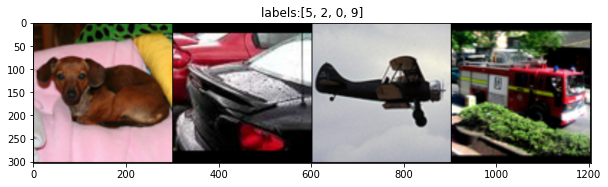

In [9]:
# display sample images
def show(img, y=None, color=True): 
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels:' + str(y))

np.random.seed(0)
torch.manual_seed(0)

grid_size = 4
rnd_ind = np.random.randint(0, len(train_ds), grid_size)

x_grid = [train_ds[i][0] for i in rnd_ind]
y_grid = [train_ds[i][1] for i in rnd_ind]

plt.figure(figsize=(10,10))
x_grid = utils.make_grid(x_grid, nrow=4, padding=2)
show(x_grid, y_grid)

Model 구축 (Conv2d 정의)

In [9]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()

        # bias=Fasle, because BN after conv includes bias.
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, bias=False, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv(x)
        return x

Stem 정의

In [9]:
class Stem(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            BasicConv2d(3, 32, 3, stride=2, padding=0), # 149 x 149 x 32
            BasicConv2d(32, 32, 3, stride=1, padding=0), # 147 x 147 x 32
            BasicConv2d(32, 64, 3, stride=1, padding=1), # 147 x 147 x 64 
        )

        self.branch3x3_conv = BasicConv2d(64, 96, 3, stride=2, padding=0) # 73x73x96

        #  kernel_size=4: 피쳐맵 크기 73, kernel_size=3: 피쳐맵 크기 74
        self.branch3x3_pool = nn.MaxPool2d(4, stride=2, padding=1) # 73x73x64

        self.branch7x7a = nn.Sequential(
            BasicConv2d(160, 64, 1, stride=1, padding=0),
            BasicConv2d(64, 96, 3, stride=1, padding=0)
        ) # 71x71x96

        self.branch7x7b = nn.Sequential(
            BasicConv2d(160, 64, 1, stride=1, padding=0),
            BasicConv2d(64, 64, (7,1), stride=1, padding=(3,0)),
            BasicConv2d(64, 64, (1,7), stride=1, padding=(0,3)),
            BasicConv2d(64, 96, 3, stride=1, padding=0)
        ) # 71x71x96

        self.branchpoola = BasicConv2d(192, 192, 3, stride=2, padding=0) # 35x35x192

        #  kernel_size=4: 피쳐맵 크기 73, kernel_size=3: 피쳐맵 크기 74
        self.branchpoolb = nn.MaxPool2d(4, 2, 1) # 35x35x192


    def forward(self, x):
        x = self.conv1(x)
        x = torch.cat((self.branch3x3_conv(x), self.branch3x3_pool(x)), dim=1)
        x = torch.cat((self.branch7x7a(x), self.branch7x7b(x)), dim=1)
        x = torch.cat((self.branchpoola(x), self.branchpoolb(x)), dim=1)
        return x

Stem 체크

In [9]:
# check Stem
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn((3, 3, 299, 299)).to(device)
model = Stem().to(device)
output_Stem = model(x)
print('Input size:', x.size())
print('Stem output size:', output_Stem.size())

InceptionResnet A모듈 정의

In [9]:
class Inception_Resnet_A(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.branch1x1 = BasicConv2d(in_channels, 32, 1, stride=1, padding=0)

        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channels, 32, 1, stride=1, padding=0),
            BasicConv2d(32, 32, 3, stride=1, padding=1)
        )

        self.branch3x3stack = nn.Sequential(
            BasicConv2d(in_channels, 32, 1, stride=1, padding=0),
            BasicConv2d(32, 48, 3, stride=1, padding=1),
            BasicConv2d(48, 64, 3, stride=1, padding=1)
        )
        
        self.reduction1x1 = nn.Conv2d(128, 384, 1, stride=1, padding=0)
        self.shortcut = nn.Conv2d(in_channels, 384, 1, stride=1, padding=0)
        self.bn = nn.BatchNorm2d(384)
        self.relu = nn.ReLU()

    def forward(self, x):
        x_shortcut = self.shortcut(x)
        x = torch.cat((self.branch1x1(x), self.branch3x3(x), self.branch3x3stack(x)), dim=1)
        x = self.reduction1x1(x)
        x = self.bn(x_shortcut + x)
        x = self.relu(x)
        return x

모듈A 확인

In [9]:
# check Inception_Resnet_A
model = Inception_Resnet_A(output_Stem.size()[1]).to(device)
output_resA = model(output_Stem)
print('Input size:', output_Stem.size())
print('output size:', output_resA.size())

Reduction A정의

In [9]:
class ReductionA(nn.Module):
    def __init__(self, in_channels, k, l, m, n):
        super().__init__()

        self.branchpool = nn.MaxPool2d(3, 2)
        self.branch3x3 = BasicConv2d(in_channels, n, 3, stride=2, padding=0)
        self.branch3x3stack = nn.Sequential(
            BasicConv2d(in_channels, k, 1, stride=1, padding=0),
            BasicConv2d(k, l, 3, stride=1, padding=1),
            BasicConv2d(l, m, 3, stride=2, padding=0)
        )

        self.output_channels = in_channels + n + m

    def forward(self, x):
        x = torch.cat((self.branchpool(x), self.branch3x3(x), self.branch3x3stack(x)), dim=1)
        return x

Reduction A 확인

In [9]:
# check ReductionA
print('input size:', output_resA.size())
model = ReductionA(output_resA.size()[1], 256, 256, 384, 384).to(device)
output_rA = model(output_resA)
print('output size:', output_rA.size())

InceptionResnet 모듈 B 정의

In [ ]:
class Inception_Resnet_B(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.branch1x1 = BasicConv2d(in_channels, 192, 1, stride=1, padding=0)
        self.branch7x7 = nn.Sequential(
            BasicConv2d(in_channels, 128, 1, stride=1, padding=0),
            BasicConv2d(128, 160, (1,7), stride=1, padding=(0,3)),
            BasicConv2d(160, 192, (7,1), stride=1, padding=(3,0))
        )

        self.reduction1x1 = nn.Conv2d(384, 1152, 1, stride=1, padding=0)
        self.shortcut = nn.Conv2d(in_channels, 1152, 1, stride=1, padding=0)
        self.bn = nn.BatchNorm2d(1152)
        self.relu = nn.ReLU()

    def forward(self, x):
        x_shortcut = self.shortcut(x)
        x = torch.cat((self.branch1x1(x), self.branch7x7(x)), dim=1)
        x = self.reduction1x1(x) * 0.1
        x = self.bn(x + x_shortcut)
        x = self.relu(x)
        return x

모듈B 확인

In [9]:
# check Inception_Resnet_B
model = Inception_Resnet_B(output_rA.size()[1]).to(device)
output_resB = model(output_rA)
print('Input size:', output_rA.size())
print('output size:', output_resB.size())

Reduction B 정의

In [9]:
class ReductionB(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.branchpool = nn.MaxPool2d(3, 2)
        self.branch3x3a = nn.Sequential(
            BasicConv2d(in_channels, 256, 1, stride=1, padding=0),
            BasicConv2d(256, 384, 3, stride=2, padding=0)
        )
        self.branch3x3b = nn.Sequential(
            BasicConv2d(in_channels, 256, 1, stride=1, padding=0),
            BasicConv2d(256, 288, 3, stride=2, padding=0)
        )
        self.branch3x3stack = nn.Sequential(
            BasicConv2d(in_channels, 256, 1, stride=1, padding=0),
            BasicConv2d(256, 288, 3, stride=1, padding=1),
            BasicConv2d(288, 320, 3, stride=2, padding=0)
        )

    def forward(self, x):
        x = torch.cat((self.branchpool(x), self.branch3x3a(x), self.branch3x3b(x), self.branch3x3stack(x)), dim=1)
        return x

ReductionB 확인

In [9]:
# check ReductionB
model = ReductionB(output_resB.size()[1]).to(device)
output_rB = model(output_resB)
print('Input size:', output_resB.size())
print('output size:', output_rB.size())

모듈 C 정의

In [9]:
class Inception_Resnet_C(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.branch1x1 = BasicConv2d(in_channels, 192, 1, stride=1, padding=0)
        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channels, 192, 1, stride=1, padding=0),
            BasicConv2d(192, 224, (1,3), stride=1, padding=(0,1)),
            BasicConv2d(224, 256, (3,1), stride=1, padding=(1,0))
        )

        self.reduction1x1 = nn.Conv2d(448, 2144, 1, stride=1, padding=0)
        self.shortcut = nn.Conv2d(in_channels, 2144, 1, stride=1, padding=0) # 2144
        self.bn = nn.BatchNorm2d(2144)
        self.relu = nn.ReLU()

    def forward(self, x):
        x_shortcut = self.shortcut(x)
        x = torch.cat((self.branch1x1(x), self.branch3x3(x)), dim=1)
        x = self.reduction1x1(x) * 0.1
        x = self.bn(x_shortcut + x)
        x = self.relu(x)
        return x

Resnet C 확인

In [9]:
# check Inception_Resnet_C
model = Inception_Resnet_C(output_rB.size()[1]).to(device)
output_resC = model(output_rB)
print('Input size:', output_rB.size())
print('output size:', output_resC.size())

정의된 모듈(A,B,C), Reduction(A,B,C)로 model 구성

In [9]:
class InceptionResNetV2(nn.Module):
    def __init__(self, A, B, C, k=256, l=256, m=384, n=384, num_classes=10, init_weights=True):
        super().__init__()
        blocks = []
        blocks.append(Stem())
        for i in range(A):
            blocks.append(Inception_Resnet_A(384))
        blocks.append(ReductionA(384, k, l, m, n))
        for i in range(B):
            blocks.append(Inception_Resnet_B(1152))
        blocks.append(ReductionB(1152))
        for i in range(C):
            blocks.append(Inception_Resnet_C(2144))

        self.features = nn.Sequential(*blocks)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        # drop out
        self.dropout = nn.Dropout2d(0.2)
        self.linear = nn.Linear(2144, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

Model.summary를 통해 model shape 확인

In [9]:
# create InceptionResNetV2
model = InceptionResNetV2(10, 20, 10).to(device)
summary(model, (3, 299, 299), device=device.type)

학습을 위한 HyperParameters 선언

In [9]:
# define loss function and optimizer
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

TRain에 필요한 함수들 정의

In [9]:
# function to get current learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# function to calculate metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b

# function to calculate loss per epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            print('Get best val_loss!')

        lr_scheduler.step(val_loss)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    return model, loss_history, metric_history

모델이 커서 5epoch만 사용

In [9]:
params_train = {
    'num_epochs':5,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

학습

In [9]:
model, loss_hist, metric_hist = train_val(model, params_train)

loss 그래프 출력

In [9]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()